the idea in this notebook involves no prior model, just trying to put a feedforward neural network with reduced state model instead of OpInf. More advanced version will not flatten anything and use convolutions.

In [1]:
import os
import opinf
import scipy.signal
# import cv2
os.getcwd()

'/home/ajivani/WLROM/WhiteLight'

In [2]:
import numpy as np
from numpy import ogrid
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf as op

In [81]:
import time

In [3]:
from sunpy.visualization import colormaps as cm

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
adjoint=True

In [6]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

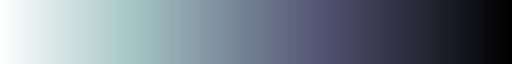

In [7]:
lc3 = cm.cmlist['soholasco3'].reversed()
lc3

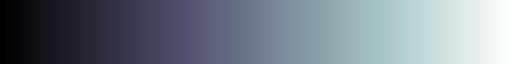

In [8]:
lc3_reg = cm.cmlist['soholasco3']
lc3_reg

In [9]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300,
       # figsize=(9, 3)
       )
plt.rc("font",
       family="serif",
       size=10
       )
plt.rc("legend", edgecolor="none", frameon=True)
plt.rc("text", usetex=True)

### Setup training and testing data

In [10]:
m = 71

In [11]:
t_vec = (np.linspace(40, 180, m) - 40) / 60
t_vec

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
       0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
       1.33333333, 1.36666667, 1.4       , 1.43333333, 1.46666667,
       1.5       , 1.53333333, 1.56666667, 1.6       , 1.63333333,
       1.66666667, 1.7       , 1.73333333, 1.76666667, 1.8       ,
       1.83333333, 1.86666667, 1.9       , 1.93333333, 1.96666667,
       2.        , 2.03333333, 2.06666667, 2.1       , 2.13333333,
       2.16666667, 2.2       , 2.23333333, 2.26666667, 2.3       ,
       2.33333333])

In [12]:
dt = t_vec[1] - t_vec[0]

In [13]:
nTrainTime = np.argwhere(t_vec == (120 - 40) / 60)[0, 0]

In [14]:
nTrainTime

40

In [15]:
nTrainTimeAll = np.argwhere(np.linspace(2, 180, 90) == 40)[0,0]

In [16]:
t_train = t_vec[:(nTrainTime + 1)]
t_train[-1] * 60 + 40

120.0

In [17]:
t_test = t_vec[(nTrainTime + 1):]
t_test

array([1.36666667, 1.4       , 1.43333333, 1.46666667, 1.5       ,
       1.53333333, 1.56666667, 1.6       , 1.63333333, 1.66666667,
       1.7       , 1.73333333, 1.76666667, 1.8       , 1.83333333,
       1.86666667, 1.9       , 1.93333333, 1.96666667, 2.        ,
       2.03333333, 2.06666667, 2.1       , 2.13333333, 2.16666667,
       2.2       , 2.23333333, 2.26666667, 2.3       , 2.33333333])

In [18]:
X_orig = np.load("./CR2161_tDecay2h_Polar_Compressed.npy")

In [19]:
X = X_orig.reshape((64 * 256, 90, 278))[:, (nTrainTimeAll):, :]

In [20]:
import netCDF4 as nc
ds = nc.Dataset("./20150315_CR2161_code_stable_tDecay2h.nc")
successfulRuns = ds['runs'].successfulRuns + 30
successfulRuns

array([ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110,
       111, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168,
       169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183,
       184, 185, 186, 188, 190, 191, 192, 193, 194, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

In [21]:
train_test_sims = np.load("./CR2161_AWSoM2T_CME_tDecay2h_Polar_Clusters.npz")
train_sim = train_test_sims["training_id"]
test_sim = train_test_sims["test_id"]
train_sim, test_sim

(array([  0,   1,   2,   3,   5,   6,   7,   8,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,  30,
         31,  32,  34,  35,  36,  37,  38,  39,  41,  42,  44,  45,  48,
         49,  50,  51,  52,  54,  55,  56,  57,  58,  59,  61,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  77,  78,
         79,  82,  84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,
         96,  98, 100, 102, 103, 104, 105, 106, 107, 108, 110, 113, 114,
        115, 116, 118, 120, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 138, 139, 140, 142, 143, 146, 147, 148,
        149, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        165, 166, 167, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 194, 196, 197,
        198, 199, 200, 201, 202, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 216, 217, 219, 220, 221, 222, 223

In [22]:
tt_sim = np.sort(np.hstack((train_sim, test_sim)))

In [23]:
X_train_ttrain = X[:, :(nTrainTime + 1), train_sim]
X_train_ttrain.shape

(16384, 41, 222)

In [24]:
X_test = X[:, :, test_sim]

In [25]:
X_train_test_ttrain = X[:, :(nTrainTime + 1), :]

In [26]:
rom_1 = op.ContinuousOpInfROM(modelform="AH")
basis_1 = op.pre.PODBasis().fit(X_train_ttrain[:, :, 0], residual_energy=1e-8)
basis_1.r

32

In [27]:
reduced_states = basis_1.encode(X_train_ttrain[:, :, 0])

In [33]:
reduced_states.shape

(32, 41)

In [51]:
reduced_states[1, :]

array([ 5.18753867,  5.4877632 ,  5.74297088,  5.93984572,  6.07472786,
        6.14135307,  6.13742178,  6.06361853,  5.92100359,  5.70977877,
        5.42965491,  5.08355595,  4.67775802,  4.21922311,  3.71461306,
        3.16796246,  2.58665005,  1.98280391,  1.36212992,  0.73077039,
        0.09351159, -0.54198027, -1.16760093, -1.77649704, -2.36307699,
       -2.92112476, -3.44261899, -3.92287053, -4.35932236, -4.74802847,
       -5.08321308, -5.36596717, -5.59438547, -5.76788039, -5.88884099,
       -5.95946237, -5.98421062, -5.96423347, -5.90416973, -5.80922226,
       -5.68420387])

### Construction of NODE Architecture

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
device

device(type='cuda', index=0)

In [30]:
t_train

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
       0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
       1.33333333])

In [67]:
data_size = t_train.shape[0]
batch_time = 5
batch_size = 10
print("Data size = ", data_size, " Batch time = ", batch_time, " Batch size = ", batch_size)

Data size =  41  Batch time =  5  Batch size =  10


In [68]:
t = torch.tensor(t_train).to(device)

In [40]:
true_y0 = torch.from_numpy(reduced_states[:, 0])
true_y0 = true_y0.reshape((1, len(true_y0))).to(device)
true_y0.shape

torch.Size([1, 32])

In [66]:
yreduced = reduced_states.T
true_y = torch.from_numpy(np.expand_dims(yreduced, axis=1)).to(device)
true_y.shape

torch.Size([41, 1, 32])

Need functions for getting batch, getting true x, getting ODE func - where we run the "loss" metric compared to the true simulation.

In [71]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64),
                                          batch_size, replace=False))
    print(s)
    batch_y0 = true_y[s]
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [72]:
by0, bt, by = get_batch()

tensor([ 3,  9, 25, 27, 12,  0,  5, 20, 13,  1])


In [78]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [86]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(32, 50),
            nn.Tanh(),
            nn.Linear(50, 32),
        )
        
        
        
        
#         self.net2 = nn.Sequential(
#             nn.Linear(32, 50),
#             nn.Tanh(),
#             nn.Linear(50, 2),
#             nn.Linear(2, 50),
#             nn.Tanh(),
#             nn.Linear(50, 32),
#         )

        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
#         for m in self.net2.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

    
    def forward(self, t, y):
        return self.net1(y)
#     def forward(self, t, y):
#         return self.net1(y) + self.net2(y**2)

Check the ODE demo in a parallel notebook and replicate these functions for our case.

In [87]:
ii = 0
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

In [88]:
niters = 100

In [ ]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % args.test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()

Try the same example but with prior learnt OpInf model.

### Scratch: Try resizing

(using coarse images for training), but Resize doesn't seem to be a good idea, we seem to be losing too much information, keep like this for now. If we use reduced states for training, it negates some of the need for resizing anyways.

In [ ]:
# X_orig.shape

In [ ]:
# scale_percent_ht = 70
# scale_percent_width = 40
# new_width = int(X.shape[1] * scale_percent_width / 100)
# new_height = int(X.shape[0] * scale_percent_ht / 100)
# new_dims = (new_width, new_height)
# print(new_dims)

In [ ]:
# x_sample_rs = cv2.resize(X_orig[:, :, nTrainTime, 0], new_dims, interpolation = cv2.INTER_AREA)

In [ ]:
# x_sample_rs.min(), x_sample_rs.max()

In [ ]:
# X_orig[:, :, nTrainTime, 0].min(), X[:, :, nTrainTime, 0].max()

In [ ]:
# fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
# axs = ax.ravel()
# im = axs[0].imshow(X_orig[:, :, nTrainTime, 0],
#               origin="lower",
#               extent=(0, 2 * np.pi, 4, 24),
#               aspect=0.05,
#               cmap=lc3_reg,
#               vmin = 0,
#               vmax = 1.5
#              )
# plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[0])

# im = axs[1].imshow(x_sample_rs,
#                   origin="lower",
#                   extent=(0, 2 * np.pi, 4, 24),
#                   aspect=0.05,
#                   cmap=lc3_reg,
#                   vmin=0,
#                   vmax=1.5
#                   )
# plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[1])